### Dataset Description

A consulting firm working for Southwest Airlines would like to predict airfares using Airfares.csv, which contains data between Q3-1996 and Q2-1997.  The variables in these data are listed below.  Some airport-to-airport data (e.g., JFK-BWI) are available, but most data are at the city-to-city level (e.g., Atlanta-Boston).  A key question is whether the presence or absence of Southwest Airlines (a low-cost entrant) would have any effect on fare. 

S_CODE:  Starting airport’s code

S_CITY:  Starting city

E_CODE:  Ending airport’s code 

E_CITY: Ending city 

COUPON:  Average number of coupons for that route  (a one-coupon flight is a nonstop flight, a two-coupon flight is a one-stop flight, etc.) 

NEW:  Number of new carriers entering that route between Q3-96 and Q2-97 

VACATION:  Whether (Yes) or not (No) a vacation route 

SW:  Whether (Yes) or not (No) Southwest Airlines serves that route 

HI:  Herfindahl index, a measure of market concentration  (higher number means smaller number of available carriers on that route) 

S_INCOME:  Starting city’s average personal income

E_INCOME:  Ending city’s average personal income 

S_POP:  Starting city’s population 

E_POP:  Ending city’s population 

SLOT:  Whether or not either endpoint airport is slot-controlled (this is a measure of airport congestion) 

GATE:  Whether or not either endpoint airport has gate constraints (this is another measure of airport congestion) 

DISTANCE:  Distance between two endpoint airports in miles 

PAX:  Number of passengers on that route during period of data collection
 
FARE:  Average fare on that route 

### Load requried Packages

In [182]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import seaborn as sns
import statistics as s
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", palette="terrain", rc=custom_params)

In [55]:
airfare_df=pd.read_csv('Airfares.csv')
df=airfare_df.drop(['S_CODE','S_CITY','E_CODE','E_CITY'],axis=1)
df.head()

,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,1.00,3,No,Yes,5291.99,28637,21112,3036732,205711,Free,Free,312,7864,96.17
1,1.06,3,No,No,5419.16,26993,29838,3532657,7145897,Free,Free,576,8820,234.71
2,1.06,3,No,No,9185.28,30124,29838,5787293,7145897,Free,Free,364,6452,284.64
3,1.06,3,No,Yes,2657.35,29260,29838,7830332,7145897,Controlled,Free,612,25144,128.21
4,1.06,3,No,Yes,2657.35,29260,29838,7830332,7145897,Free,Free,612,25144,128.21


## 1Question

Create a correlation table and scatterplots between FARE and the predictors.What seems to be the best single predictor of FARE? Explain your answer. 

<AxesSubplot:>

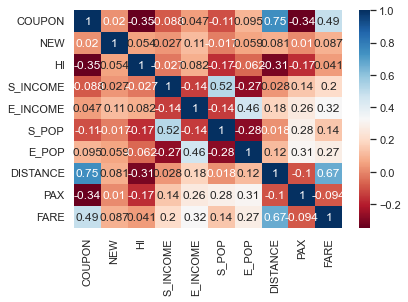

In [56]:
corr=df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True,cmap="RdBu")


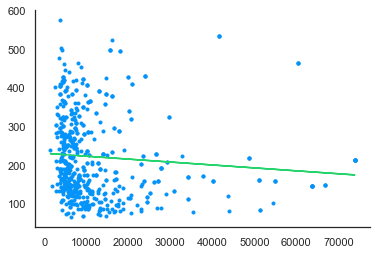

In [57]:
x = airfare_df.PAX
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)



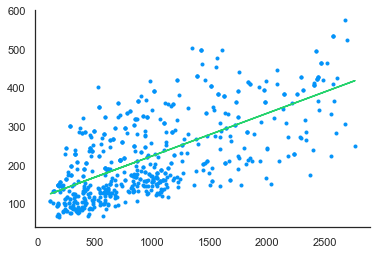

In [58]:
x = airfare_df.DISTANCE
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

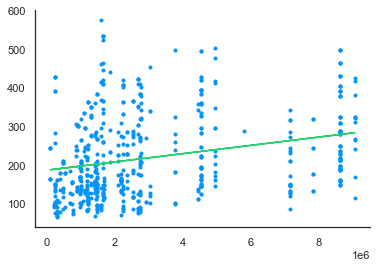

In [59]:
x = airfare_df.E_POP
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

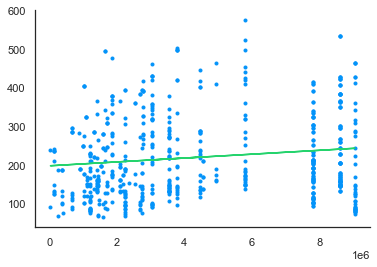

In [60]:
x = airfare_df.S_POP
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

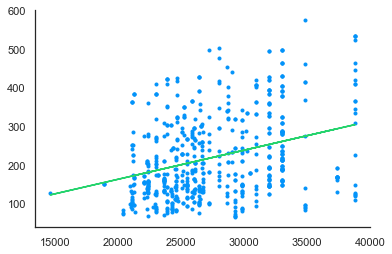

In [61]:
x = airfare_df.E_INCOME
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)


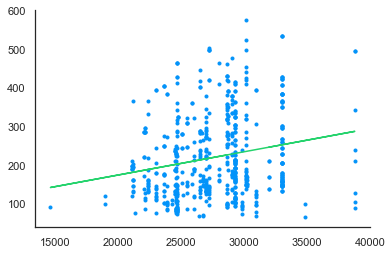

In [62]:
x = airfare_df.S_INCOME
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

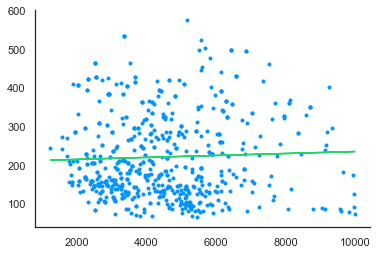

In [63]:
x = airfare_df.HI
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

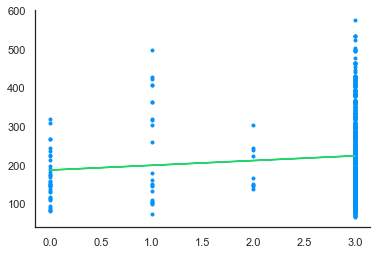

In [64]:
x = airfare_df.NEW
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

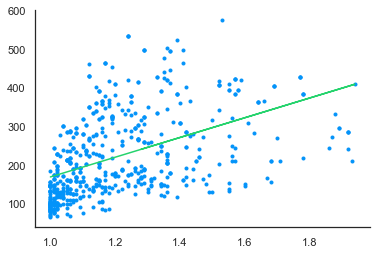

In [65]:
x = airfare_df.COUPON
y = airfare_df.FARE
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')

plt.plot(x, m*x + b)

### 1Q Response

From Correlation matrix we can say that :
Variables COUPON and DISTANCE(0.75),FARE and DISTANCE(0.67), has strong positive correlation (when one variable increases then the other also increases or if one variable decreases then the other also decreases)
Variables COUPON and HI(-0.35),COUPON and FAX(-0.34),DISTANCE and HI(-0.31) has strong negative correlation (when one variable decreases then the other increases or when one variable increases then other decreases)
With Respect to FARE:FARE has a strong correlation with DISTANCE(0.67),COUPON(0.49),E_INCOME(0.32),E_POP(0.27) hence positive change can also be seen in the graphs above.

Based on the scatter plots presented above, we can conclude that as the distance increases, so will the fare, as the two variables have the largest positive association.

## 2Question

Explore the categorical predictors by computing the percentage of flights in each category. Create a pivot table with the average fare in each category.Which categorical predictor seems best for predicting FARE? Explain your answer. 

In [171]:
c=(df.VACATION.value_counts()/len(df)).round(3)*100
print("Percentage of Flights: \n",c)
df.pivot_table('FARE','VACATION',aggfunc={'mean','sum'})

Percentage of Flights: 
 No     73.4
Yes    26.6
Name: VACATION, dtype: float64


,mean,sum
VACATION,,
No,239.215791,111952.99
Yes,168.327059,28615.60


In [170]:
c=(df.SW.value_counts()/len(df)).round(3)*100
print("Percentage of Flights: \n ",c)
df.pivot_table('FARE','SW',aggfunc={'mean','sum'})

Percentage of Flights: 
  No     69.6
Yes    30.4
Name: SW, dtype: float64


,mean,sum
SW,,
No,256.675428,113963.89
Yes,137.137629,26604.70


In [169]:
c=(df.SLOT.value_counts()/len(df)).round(3)*100
print("Percentage of Flights: \n ",c)
df.pivot_table('FARE','SLOT',aggfunc={'mean','sum'})

Percentage of Flights: 
  Free          71.5
Controlled    28.5
Name: SLOT, dtype: float64


,mean,sum
SLOT,,
Controlled,253.575385,46150.72
Free,207.056732,94417.87


In [168]:
c=(df.GATE.value_counts()/len(df)).round(3)*100
print("Percentage of Flights: \n ",c)
df.pivot_table('FARE','GATE',aggfunc={'mean','sum'})

Percentage of Flights: 
  Free           80.6
Constrained    19.4
Name: GATE, dtype: float64


,mean,sum
GATE,,
Constrained,263.784839,32709.32
Free,209.842938,107859.27


Vaction category having a mean of 168.327059 for positive response where as SW category having a mean of 137.137629 for positive response.In comparison of both vaction category is having more mean when compared to SW category so vaction predictor seems best for predicting FARE when both vaction and sw  are compared.

SLOT category having a mean of 207.056732  for  free response where as GATE category having a mean of 209.842938 for free response. In comparison of both GATE category is having more mean when compared to SLOT category so GATE predictor seems best for predicting FARE when both SLOT and GATE  are compared. 



## 3Question

Create data partition by assigning 80% of the records to the training dataset. Set the seed at 123 for replicability, if needed.

In [173]:
df.isnull().sum()


COUPON       0
NEW          0
VACATION     0
SW           0
HI           0
S_INCOME     0
E_INCOME     0
S_POP        0
E_POP        0
SLOT         0
GATE         0
DISTANCE     0
PAX          0
FARE         0
%VACATION    0
dtype: int64

In [175]:
df.dropna()
df.shape

(638, 15)

In [180]:
reg = LinearRegression()
X = pd.get_dummies(df[['COUPON','NEW','VACATION','SW','HI','S_INCOME','E_INCOME','S_POP','E_POP','SLOT','GATE','DISTANCE']], drop_first=True)
Y = df['FARE']
train_X, valid_X, train_y, valid_y = train_test_split(X, Y, test_size=0.2, random_state=123)
reg.fit(train_X,train_y)
print(train_X.shape, valid_X.shape, train_y.shape, valid_y.shape)
train_y.head()

(510, 12) (128, 12) (510,) (128,)


511    263.25
298    318.84
177    212.57
403    116.43
171    148.17
Name: FARE, dtype: float64

To train the dataset, we need to check for count of nulls present by using pre-defined function "df.isnull().sum()". After checking the null values in the dataset, it is eliminated with function "df.dropna()". The "df.dropna()" pre-defined function removes rows and columns with null/none values. To know the remaining number of columns and rows, "df.shape" is used. From the above dataset, they are 638 rows and 15 columns after cleansing the data.

Now, let's apply the linear regression function to the predict the target variable based on independent variables. The "pd.get_dummies()" function is used to transform the categorical variables into dummy variables (i.e., 0 and 1 depending upon the count of input variables). In that way, input variables are transformed. The target variable "Fare" column is stored in variable Y.

After the data manipulation, the training and testing dataset is divided into 80% and 20% respectively by using "train_test_split" function with random_state given 123. Now, the fit() function is applied to the train dataset in order to get ideal regression line that fits the distribution of input X and target Y as shown above.

## 4Question

Run a stepwise selection regression model to reduce the number of predictors. 
Discuss the results from this model.

In [183]:
print('intercept ', reg.intercept_)
regressionSummary(train_y, reg.predict(train_X))

intercept  -34.12240758742331

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 51.8657
            Mean Absolute Error (MAE) : 41.1329
          Mean Percentage Error (MPE) : -4.8021
Mean Absolute Percentage Error (MAPE) : 22.2618


In [184]:
y_predict =reg.predict(valid_X)
regressionSummary(valid_y,y_predict)


Regression statistics

                      Mean Error (ME) : -1.4011
       Root Mean Squared Error (RMSE) : 55.7883
            Mean Absolute Error (MAE) : 44.2052
          Mean Percentage Error (MPE) : -6.2291
Mean Absolute Percentage Error (MAPE) : 22.7895


def train_model(variables): 
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print("Best variables according to stepwise selection model",best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

In order to reduce number of predictors, let's know the statistics of the training dataset by using "regressionSummary()" which shows the Mean Error, Root Mean Squared Error, Mean Absolute Error, Mean Percentage Error, Mean Absolute Percentage Error as shown above for validation and train data respectively.

From statistics, we can observe that error for train Y is less comparatively with validation Y. Further, to select the more important variables, we input the variables to stepwise_selection funnction. Based on the score, variable selection is decided.

As shown above, 'Distance', 'Vacation_Yes', 'SW_Yes', 'Hi', 'Slot_Free', 'Gate_Free', 'E_Income', 'S_Pop', 'Coupon', 'E_Pop', 'New', 'S_Income' are the best variables.

Regression Statistics are calculated for Validation X variables.

## 5Question

Repeat the process in (4) using exhaustive search instead of forward selection.

In [186]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 200)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')


print(pd.DataFrame(data).columns)

air_exhaust=['COUPON', 'NEW', 'HI', 'S_INCOME', 'E_INCOME','S_POP', 'E_POP', 'DISTANCE', 'VACATION_Yes', 'SW_Yes', 'SLOT_Free','GATE_Free']
print("\n \n Best variables according to exhaustive model: \n",air_exhaust)
regressionSummary(valid_y, model.predict(valid_X))

     n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP  GATE_Free     HI    NEW  SLOT_Free  SW_Yes  S_INCOME  S_POP  VACATION_Yes
0    1  0.422733  5921.793145   False      True     False  False      False  False  False      False   False     False  False         False
1    2  0.557236  5787.501775   False      True     False  False      False  False  False      False   False     False  False          True
2    3  0.679770  5623.256534   False      True     False  False      False  False  False      False    True     False  False          True
3    4  0.710033  5573.619061   False      True     False  False      False   True  False      False    True     False  False          True
4    5  0.725451  5546.743418   False      True     False  False      False   True  False       True    True     False  False          True
5    6  0.738784  5522.339862   False      True     False  False       True   True  False       True    True     False  False          True
6    7  0.740603  55

Exhaustive Search is almost similar to forward search but latter one is cheaper. With help of Exhaustive search, the backend encoder will generate subframes for every order and use the smallest. This search begins with best one-component subset of input features, then continues with best second-component, goes on with third best component subset.

As shown, best variables are declared with exhaustive_search function. Also, regression summary is calculated for validation dataset.

## 6Question

Compare the predictive accuracy of both models—stepwise selection and 
exhaustive search—using measures such as RMSE and average error.

In [ ]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(train_y.values, pred_y)))
print("Mean absolute % error: ", round(mean_absolute_percentage_error(train_y.values, pred_y)))
print("R-squared: ", r2_score(train_y.values, pred_y))

## 7Question

Using the exhaustive search model, predict the average fare on a route with the 
following characteristics: COUPON = 1.202, NEW = 3, VACATION = No, SW = 
No, HI = 4442.141, S_INCOME = $28,760, E_INCOME = $27,664, S_POP = 
4,557,004, E_POP = 3,195,503, SLOT = Free, GATE = Free, PAX = 12,782, 
DISTANCE = 1976 miles. 

In [190]:
E_model = LinearRegression()
E_model.fit(train_X[air_exhaust], train_y)

LinearRegression()

In [195]:
Variable_df = pd.DataFrame({
                    "COUPON":[1.202],
                    "NEW":[3],
                    "HI":[4442.141],
                    "S_INCOME":[28760],
                    "E_INCOME":[27664],
                    "S_POP":[4557004],
                    "E_POP":[3195503],
                    "DISTANCE":[1976],
                    "VACATION":[0],
                    "SW":[0],
                    "SLOT_Free":[1],
                    "GATE_Free":[1]})

In [194]:

E_predict = E_model.predict(Variable_df)
print("Average fare predicted value according to the new given values:\t",E_predict)


Average fare predicted value according to the new given values:	 [342.35310464]


C:\Users\Amulya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- SW
- VACATION
Feature names seen at fit time, yet now missing:
- SW_Yes
- VACATION_Yes

  warnings.warn(message, FutureWarning)


To calculate average fare predicted value, input (independent) variable values for the selected variabls are provided in the dataframe as shown. Linear regression is performed and fit function is applied to get the ideal regression line for the input and output data. The final target value is predicted by using predict function i.e., 342.35.

## 8Question

Predict the reduction in average fare on the route in question (7.), if Southwest 
decides to serve this route.

In [196]:
Variable2_df = pd.DataFrame({
                    "COUPON":[1.202],
                    "NEW":[3],
                    "HI":[4442.141],
                    "S_INCOME":[28760],
                    "E_INCOME":[27664],
                    "S_POP":[4557004],
                    "E_POP":[3195503],
                    "DISTANCE":[1976],
                    "VACATION":[0],
                    "SW":[1],
                    "SLOT_Free":[1],
                    "GATE_Free":[1]})

In [198]:

E_predict2= E_model.predict(Variable2_df)
print("Average fare predicted value according to the SW decides to serve this route:\t",E_predict)
print("Reduced fare",E_predict-E_predict2)

Average fare predicted value according to the SW decides to serve this route:	 [342.35310464]
Reduced fare [50.6505035]


C:\Users\Amulya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- SW
- VACATION
Feature names seen at fit time, yet now missing:
- SW_Yes
- VACATION_Yes

  warnings.warn(message, FutureWarning)


Similar to last step, value for the SW (i.e., SouthWest) is changed to 1,
as it is decided to serve the route. Upon calculation with help of using
predict function, we obtain value approximately as 392.9. So, reduced fare difference is
50.65 
